during the ETLT
1. combine both motorist and sgcarmart
2. names to be extracted -> brand and model 
3. fetch data from API
4. combine both APIs together to get 1 dataset
5. derive the vehicle classes
6. fetch the COE prices

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

In [15]:
# read dataset first
# data = pd.read_csv('../Datasets/final_combined_dataset.csv')

path_to_private_key = 'is3107-418903-a6116d294003.json'
bigquery_client = bigquery.Client.from_service_account_json(json_credentials_path=path_to_private_key)

sql = """
        SELECT * FROM `is3107-418903.final.carsCombinedFinal`
        """
data = bigquery_client.query(sql).to_dataframe()

In [16]:
data.dropna()

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,accessories,make,model,year,model_make_id,model_name,model_trim,model_year,model_body,model_seats,model_weight_kg,model_engine_fuel,model_engine_cyl,model_drive,model_transmission_type,model_fuel_cap_l,vehicle_class
1,1,1984.0,147999.0,25559.0,54000.0,2130.0,4.60,49779.0,61691.0,"Audi Virtual cockpit, Smartphone interface, Na...",AUDI,S3,2018,124,S3,12325,2018,Sedan,5,1569.614512,premium unleaded (required),I4,all wheel drive,7-speed automated manual,54.8825,B
2,1,1987.0,116800.0,17727.0,103200.0,1270.0,5.60,29507.0,33310.0,"Sunroof. Leather upholstery, sports rims, smar...",TOYOTA,RAV4,2019,374,RAV4,11918,2019,SUV,5,1639.455782,regular unleaded,I4,all wheel drive,8-speed shiftable automatic,54.8825,B
3,1,1798.0,80000.0,25912.0,75000.0,1400.0,2.30,39395.0,42153.0,"Auto Head Lights, Electric Folding Side Mirror...",AUDI,A6,2016,106,A6,18299,2016,Sedan,5,1724.716553,premium unleaded (recommended),I4,front wheel drive,7-speed automated manual,74.9430,B
4,1,1991.0,98888.0,17430.0,94000.0,155.0,4.67,30477.0,34668.0,Auto LED headlights and daytime lights. Rain s...,Infiniti,Q50,2018,45,Q50,13652,2018,Sedan,5,1689.795918,premium unleaded (required),I4,rear wheel drive,7-speed shiftable automatic,75.7000,B
6,1,1991.0,80999.0,16980.0,75000.0,1550.0,3.60,34564.0,40390.0,"Auto LED headlights w DRL, keyless entry & eng...",INFINITI,Q50,2017,45,Q50,16649,2017,Sedan,5,1656.235828,premium unleaded (required),I4,rear wheel drive,7-speed shiftable automatic,75.7000,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,3,1969.0,127800.0,17242.0,60000.0,1400.0,6.30,33814.0,39340.0,"18"" Forged Rims. Big Brake Kits. Touch Screen ...",VOLVO,S60,2020,88,S60,9117,2020,Sedan,5,1658.503401,premium unleaded (recommended),I4,front wheel drive,8-speed shiftable automatic,54.8825,B
103,3,1395.0,71800.0,16431.0,119000.0,1100.0,3.50,32727.0,27818.0,Audi MMI with Bluetooth. Multi function steeri...,AUDI,A4,2017,104,A4,15295,2017,Sedan,5,1579.591837,premium unleaded (recommended),I4,front wheel drive,7-speed automated manual,57.9105,B
105,3,1591.0,66868.0,13560.0,83000.0,93.8,4.46,12630.0,12630.0,Reverse camera and sensors. Leather seats. Spo...,Hyundai,Elantra,2018,440,Elantra,13580,2018,Hatchback,5,1334.693878,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,52.9900,A
106,3,1595.0,66800.0,23170.0,130000.0,115.0,2.26,29913.0,28879.0,"Bodykit, upgraded rims, AMG BBK, Electric tail...",Mercedes-Benz,GLA-Class,2016,305,GLA-Class,20068,2016,SUV,5,1567.800454,premium unleaded (required),I4,all wheel drive,7-speed automated manual,56.0180,B


# Data Processing

In [17]:
# checking the data types
data.dtypes

owners                       Int64
eng_cap                    float64
price                      float64
depreciation               float64
mileage                    float64
power                      float64
coe_left                   float64
omv                        float64
arf                        float64
accessories                 object
make                        object
model                       object
year                         Int64
model_make_id                Int64
model_name                  object
model_trim                   Int64
model_year                   Int64
model_body                  object
model_seats                  Int64
model_weight_kg            float64
model_engine_fuel           object
model_engine_cyl            object
model_drive                 object
model_transmission_type     object
model_fuel_cap_l           float64
vehicle_class               object
dtype: object

In [18]:
# # converting to integers
# data['model_year'] = data['model_year'].astype("Int64")
# data['model_seats'] = data['model_seats'].astype("Int64")

# # 2dp 
# data['model_weight_kg'] = data['model_weight_kg'].round(2)
# data['model_fuel_cap_l'] = data['model_fuel_cap_l'].round(2)

# # converting to datetime
# data['reg_date'] = pd.to_datetime(data['reg_date'])

# drop model trim
columns_to_drop = ['model_trim', 'accessories', 'model_make_id', 'vehicle_class']
data = data.drop(columns=columns_to_drop)

## Encoding Model Body

In [19]:
# before replacing data 
print(data['model_body'].value_counts())

model_body
None           47
SUV            31
Sedan          23
Hatchback      16
Convertible     4
Coupe           3
Minivan         2
Name: count, dtype: int64


In [30]:
data['model_body'][0].lower()

'none'

In [13]:
# encode model_body

for index, row in data.iterrows():
    row['model_body'] = row['model_body'].lower()
    if 'sport' in row['model_body']:
        data.at[index, 'model_body'] ='SUV'
    elif 'compact' in row['model_body'] or 'subcompact' in row['model_body']:
        data.at[index, 'model_body'] ='Compact Cars'
    elif 'manual' in row['model_body']:
        data.at[index, 'model_body'] ='Manual'
    elif 'wagon' in row['model_body']:
        data.at[index, 'model_body'] ='Wagon'
        
# after replacing data 
print(data['model_body'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_body'], drop_first=True)

model_body
None           47
SUV            31
Sedan          23
Hatchback      16
Convertible     4
Coupe           3
Minivan         2
Name: count, dtype: int64


## Encoding Model Transmission Type

In [88]:
# before replacing data 
print(data['model_transmission_type'].value_counts())

model_transmission_type
8-speed shiftable automatic              18
continuously variable-speed automatic    15
6-speed shiftable automatic              11
7-speed automated manual                 10
6-speed manual                            9
6-speed automated manual                  3
7-speed shiftable automatic               3
9-speed shiftable automatic               2
4-speed automatic                         1
5-speed manual                            1
10-speed shiftable automatic              1
6-speed automatic                         1
Name: count, dtype: int64


In [89]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_transmission_type'] = row['model_transmission_type'].lower()
    if 'continuously' in row['model_transmission_type'] or 'single Speed' in row['model_transmission_type'] or 'cvt' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='CVT'
    elif 'automatic' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automatic'
    elif 'manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Manual'
    elif 'automated manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automated Manual'
    else:
        data.at[index, 'model_transmission_type'] ='Others'

# after replacing data
print(data['model_transmission_type'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_transmission_type'], drop_first=True)


model_transmission_type
Automatic    37
Manual       23
CVT          15
Name: count, dtype: int64


## Encoding Model Drive

In [90]:
# before replacing data 
print(data['model_drive'].value_counts())

model_drive
front wheel drive    41
all wheel drive      21
rear wheel drive     11
four wheel drive      2
Name: count, dtype: int64


In [91]:
#encode model_drive
for index, row in data.iterrows():
    row['model_drive'] = row['model_drive'].lower()
    if 'all' in row['model_drive'] or '4wd' in row['model_drive'] or 'awd' in row['model_drive'] or 'four' in row['model_drive']:
        data.at[index, 'model_drive'] ='All Wheel Drive'
    elif 'front' in row['model_drive']:
        data.at[index, 'model_drive'] ='Front Wheel Drive'
    elif 'rear' in row['model_drive']:
        data.at[index, 'model_drive'] ='Rear Wheel Drive'
    else:
        data.at[index, 'model_drive'] ='Others'
        

# after replacing data
print(data['model_drive'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_drive'], drop_first=True)

model_drive
Front Wheel Drive    41
All Wheel Drive      23
Rear Wheel Drive     11
Name: count, dtype: int64


## Encoding Model Engine Fuel

In [92]:
# before replacing data 
print(data['model_engine_fuel'].value_counts())

model_engine_fuel
regular unleaded                  31
premium unleaded (recommended)    23
premium unleaded (required)       20
diesel fuel                        1
Name: count, dtype: int64


In [93]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_engine_fuel'] = row['model_engine_fuel'].lower()
    if 'premium' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Premium'
    elif 'regular' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'hybrid' in row['model_engine_fuel'] or 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Hybrid'
    elif 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'diesel' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Diesel'
    elif 'electric' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Electric'
    else:
        print(row['model_engine_fuel'])
        data.at[index, 'model_engine_fuel'] ='Others'

# after replacing data

print(data['model_engine_fuel'].value_counts())


# nominal encoding
data = pd.get_dummies(data, columns=['model_engine_fuel'], drop_first=True)


model_engine_fuel
Premium    43
Regular    31
Diesel      1
Name: count, dtype: int64


## Encoding Model Engine Cylinders

In [94]:
# before replacing data 
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
I4        58
V6         6
flat 4     5
I6         3
V8         2
flat 6     1
Name: count, dtype: int64


In [95]:
# convert all values to string first
data['model_engine_cyl'] = data['model_engine_cyl'].astype("string")

for index, row in data.iterrows():
    row['model_engine_cyl'] = row['model_engine_cyl'].lower()
    if '2' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='2'
    elif '3' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='3'
    elif '4' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='4'
    elif '5' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='5'
    elif '6' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='6'
    elif '8' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='8'
    elif '10' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='10'
    elif '12' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='12'

    

#convert back to int
data['model_engine_cyl'] = data['model_engine_cyl'].astype("Int64")
# after replacing data
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
4    63
6    10
8     2
Name: count, dtype: Int64


# Change reg_date into numerical data

In [7]:
data['years_since_reg'] = 0

for i in range(len(data)):
    row = data.iloc[i]
    year = row['model_year']
    data.at[i, 'years_since_reg'] = 2024-year

data = data.drop(columns=['model_year'])

## Encoding Model
we will classify the car models into 3 categories

In [97]:
brands = {
    'budget' : ['Chevrolet', 'Citroen', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mitsubishi', 'Nissan', 'Peugeot', 'Renault', 'Skoda', 'Ssangyong', 'Subaru', 'Suzuki', 'Toyota', 'Daihatsu', 'Proton'],
    'mid' : ['Alfa Romeo', 'Chrysler', 'Infiniti', 'MINI', 'Opel', 'Saab', 'Volkswagen', 'Audi', 'BMW', 'Jaguar', 'Jeep', 'Lexus', 'Lotus', 'Mercedes-Benz', 'Mercedes Benz', 'Mitsuoka', 'Volvo', 'Dodge Journey'],
    'exotic' : ['Aston Martin', 'Ferrari', 'Lamborghini', 'McLaren', 'Bentley', 'Land-Rover', 'Land Rover', 'Maserati', 'Porsche', 'Rolls-Royce', 'Rolls Royce']
}

In [98]:
data['brands'] = "others"

for i in range(len(data)):
    row = data.iloc[i]
    model = row['make']
    for group, brand_list in brands.items():
        for brand in brand_list:
            if brand.lower() in model.lower():
                data.at[i, 'make'] = group
            


In [99]:
print(data['brands'].value_counts())

brands
others    75
Name: count, dtype: int64


In [100]:
# ordinal encoding of the car brands
ordinal_mapping = {
    'budget': 1,
    'mid': 2,
    'exotic' : 3,
    'others' : 1.5
}
data['brands'] = data['brands'].map(ordinal_mapping)
data = data.drop(columns=['make'])

# Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Plot with Features')

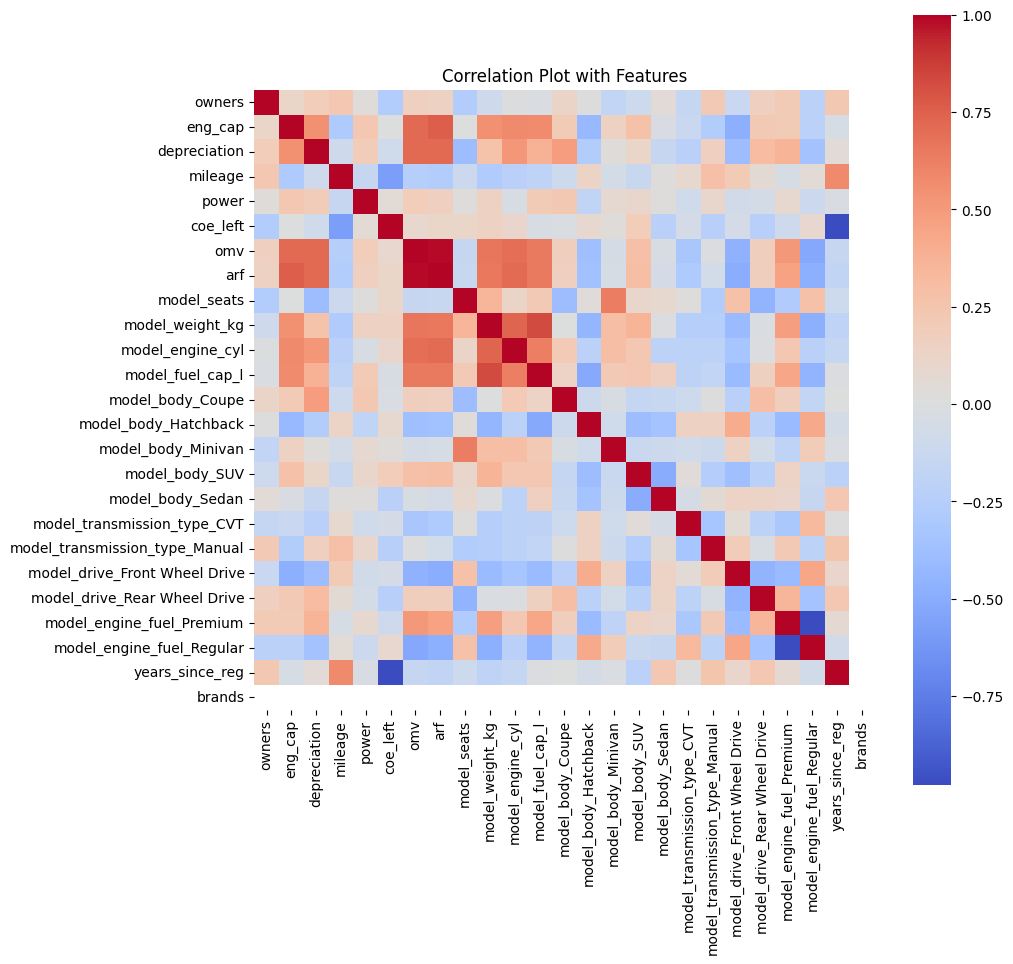

In [101]:
# plotting correlation heatmap between numeric variables

independent_vars = data.drop(columns=['price'])

correlation = independent_vars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, cmap="coolwarm")
plt.title("Correlation Plot with Features")

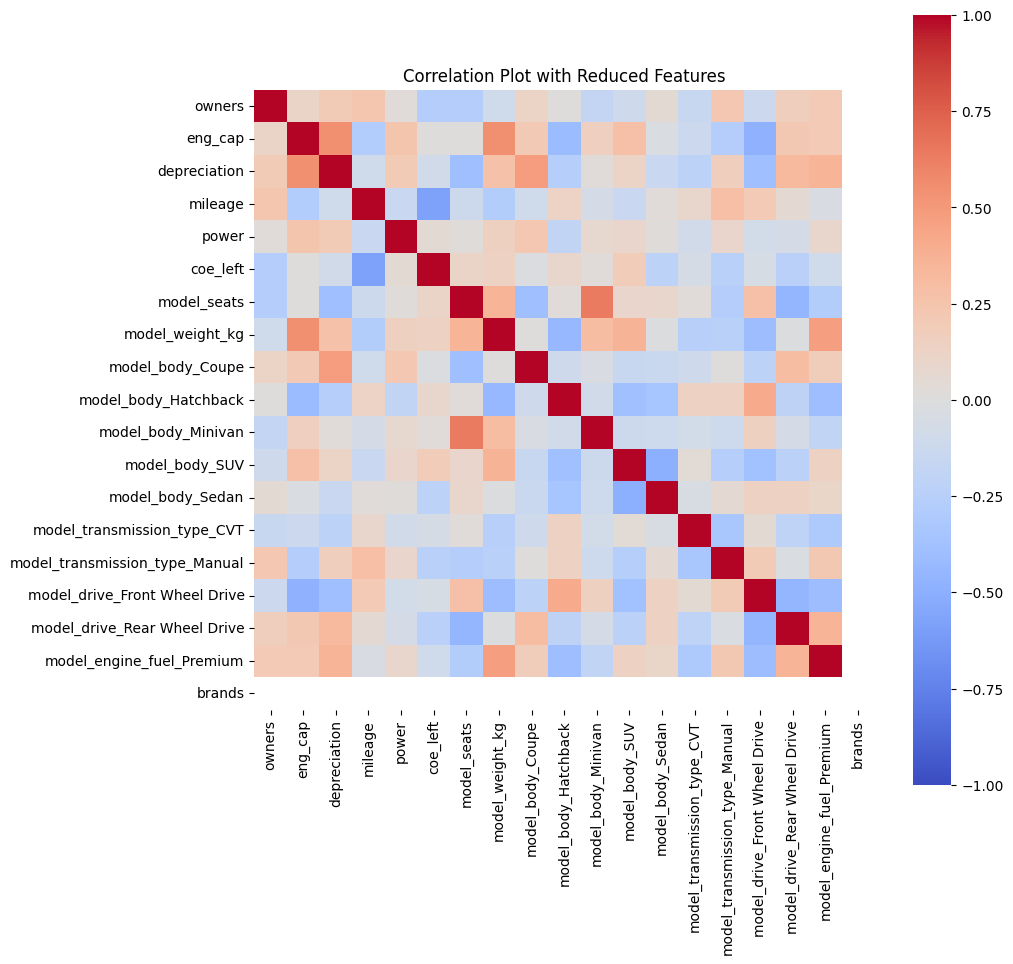

In [102]:
#identify pairs of highly correlated features
threshold = 0.7
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# remove these columns from the DataFrame
independent_vars = independent_vars.drop(columns=to_drop)

# calculate the corr again
corr_reduced = independent_vars.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_reduced, vmax=1, vmin=-1, square=True, cmap="coolwarm")
plt.title('Correlation Plot with Reduced Features')
plt.show()

In [103]:
# might change after combining with coe price
print(independent_vars.columns)
Y = data['price']

Index(['owners', 'eng_cap', 'depreciation', 'mileage', 'power', 'coe_left',
       'model_seats', 'model_weight_kg', 'model_body_Coupe',
       'model_body_Hatchback', 'model_body_Minivan', 'model_body_SUV',
       'model_body_Sedan', 'model_transmission_type_CVT',
       'model_transmission_type_Manual', 'model_drive_Front Wheel Drive',
       'model_drive_Rear Wheel Drive', 'model_engine_fuel_Premium', 'brands'],
      dtype='object')


# Linear Regression

In [104]:
# split the data up for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 29905.69372249822
MSE: 7016675758.973286
RMSE: 83765.60009319629
R^2: -0.421467780245941
Adjusted R^2: 4.980109784688635


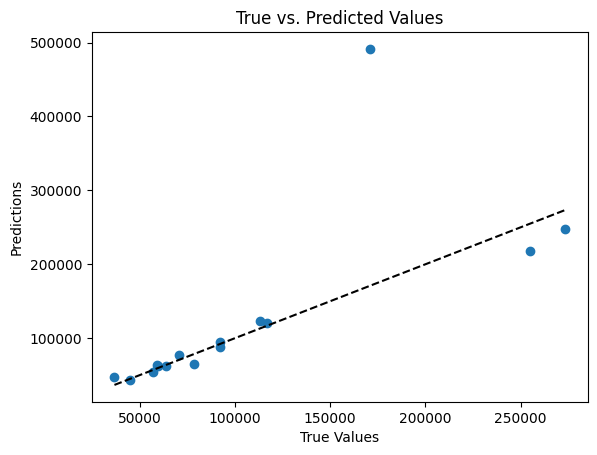

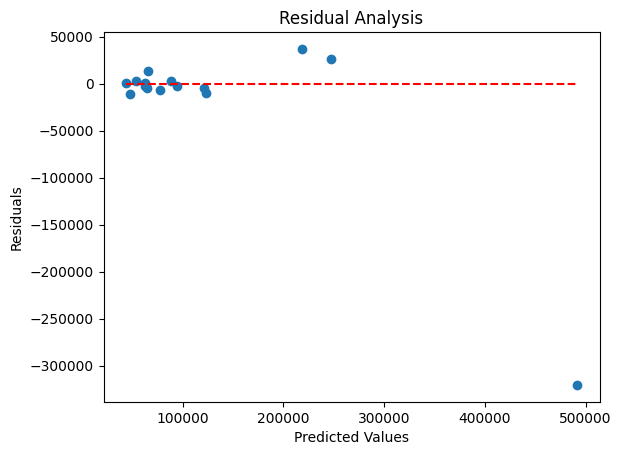

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_93357/1653121044.py:42: RuntimeWarning: overflow encountered in power
  linear_regressor_predicted['predicted_price'] = np.power(10, predicted_price_LR)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,2,1580.0,56800.0,16954.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,False,True,7,1.5,inf
1,1,1395.0,139999.0,19407.0,74000.0,1100.0,6.40,27819.0,30947.0,5,1770.975057,4,60.1815,False,False,False,True,False,False,False,False,False,True,False,4,1.5,inf
2,2,1395.0,94800.0,18002.0,92434.0,1100.0,4.30,31231.0,35724.0,5,1543.764172,4,63.9665,False,False,False,True,False,False,False,True,False,True,False,6,1.5,inf
3,2,2979.0,278000.0,39781.0,38800.0,3160.0,4.90,107313.0,165164.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
4,1,2979.0,273500.0,39330.0,78000.0,257.0,5.18,93071.0,139528.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,1395.0,45800.0,15902.0,120893.0,920.0,2.40,22519.0,13527.0,5,1639.909297,4,40.1210,False,True,False,False,False,False,True,True,False,True,False,8,1.5,inf
71,3,1998.0,60800.0,14900.0,118000.0,1110.0,3.50,17342.0,17342.0,2,1108.843537,4,45.0415,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
72,2,1988.0,218000.0,53040.0,115000.0,220.0,3.17,70951.0,99712.0,2,1335.147392,4,54.1255,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
73,2,1395.0,23800.0,17408.0,126000.0,920.0,0.90,27195.0,15073.0,4,1529.705215,4,49.9620,False,False,False,False,False,False,True,True,False,True,False,9,1.5,inf


In [105]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_LR_train, y_LR_train)
y_LR_pred = linear_regressor.predict(X_LR_test)

# Calculate R-squared
n_LR = X_LR_test.shape[0]  # number of observations
p_LR = X_LR_test.shape[1]  # number of features
mae_LR = mean_absolute_error(y_LR_test, y_LR_pred)
mse_LR = mean_squared_error(y_LR_test, y_LR_pred)
rmse_LR = mean_squared_error(y_LR_test, y_LR_pred, squared=False)
r2_LR = r2_score(y_LR_test, y_LR_pred)
adjusted_r2_LR = 1 - (1 - r2_LR) * ((n_LR - 1) / (n_LR - p_LR - 1))
print(f"MAE: {mae_LR}")
print(f"MSE: {mse_LR}")
print(f"RMSE: {rmse_LR}")
print(f"R^2: {r2_LR}")
print(f"Adjusted R^2: {adjusted_r2_LR}")

#plotting True VS Predicted
plt.scatter(y_LR_test, y_LR_pred)
plt.plot([y_LR_test.min(), y_LR_test.max()], [y_LR_test.min(), y_LR_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_LR = y_LR_test - y_LR_pred
plt.scatter(y_LR_pred, residuals_LR)
plt.hlines(y=0, xmin=y_LR_pred.min(), xmax=y_LR_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars 
predicted_price_LR = linear_regressor.predict(x)
linear_regressor_predicted = data.copy()
linear_regressor_predicted['predicted_price'] = np.power(10, predicted_price_LR)
linear_regressor_predicted

# Best Lasso

In [106]:
# split the data up for testing

X_Lasso_train, X_Lasso_test, y_Lasso_train, y_Lasso_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

Best alpha: 100
MAE: 30591.91182819587
MSE: 7487763992.55028
RMSE: 86531.8669193626
R^2: -0.5169028222352055
Adjusted R^2: 5.247327902258575


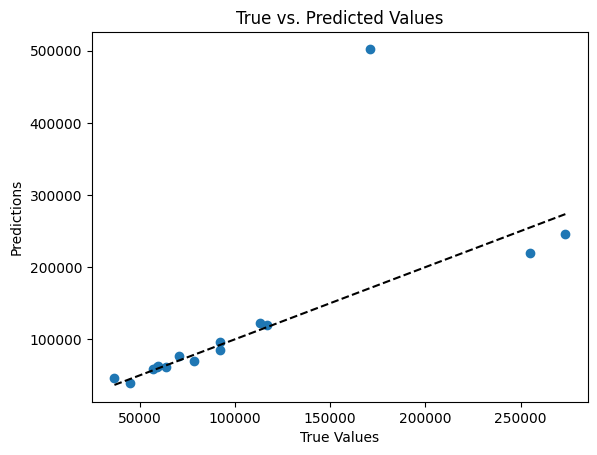

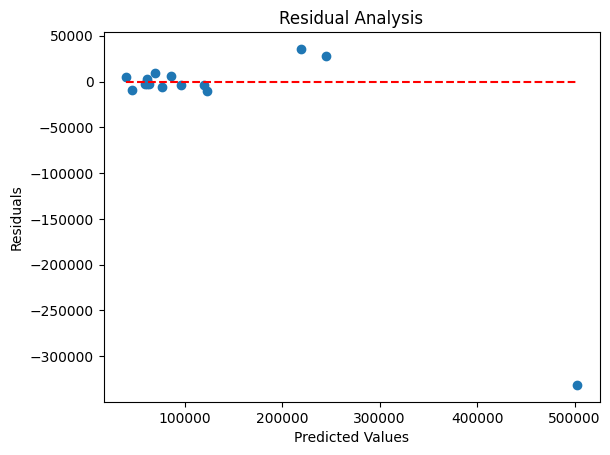

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_93357/3284264278.py:52: RuntimeWarning: overflow encountered in power
  lasso_predicted_results['predicted_price'] = np.power(10, predicted_price_Lasso)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,2,1580.0,56800.0,16954.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,False,True,7,1.5,inf
1,1,1395.0,139999.0,19407.0,74000.0,1100.0,6.40,27819.0,30947.0,5,1770.975057,4,60.1815,False,False,False,True,False,False,False,False,False,True,False,4,1.5,inf
2,2,1395.0,94800.0,18002.0,92434.0,1100.0,4.30,31231.0,35724.0,5,1543.764172,4,63.9665,False,False,False,True,False,False,False,True,False,True,False,6,1.5,inf
3,2,2979.0,278000.0,39781.0,38800.0,3160.0,4.90,107313.0,165164.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
4,1,2979.0,273500.0,39330.0,78000.0,257.0,5.18,93071.0,139528.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,1395.0,45800.0,15902.0,120893.0,920.0,2.40,22519.0,13527.0,5,1639.909297,4,40.1210,False,True,False,False,False,False,True,True,False,True,False,8,1.5,inf
71,3,1998.0,60800.0,14900.0,118000.0,1110.0,3.50,17342.0,17342.0,2,1108.843537,4,45.0415,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
72,2,1988.0,218000.0,53040.0,115000.0,220.0,3.17,70951.0,99712.0,2,1335.147392,4,54.1255,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
73,2,1395.0,23800.0,17408.0,126000.0,920.0,0.90,27195.0,15073.0,4,1529.705215,4,49.9620,False,False,False,False,False,False,True,True,False,True,False,9,1.5,inf


In [107]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso()
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#looping through to find best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_Lasso_train, y_Lasso_train)

lasso = grid_search.best_estimator_
y_Lasso_pred = lasso.predict(X_Lasso_test)
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Calculate R-squared
n_Lasso = X_Lasso_test.shape[0]  # number of observations
p_Lasso = X_Lasso_test.shape[1]  # number of features
mae_Lasso = mean_absolute_error(y_Lasso_test, y_Lasso_pred)
mse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred)
rmse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred, squared=False)
r2_Lasso = r2_score(y_Lasso_test, y_Lasso_pred)
adjusted_r2_Lasso = 1 - (1 - r2_Lasso) * ((n_Lasso - 1) / (n_Lasso - p_Lasso - 1))
print(f"MAE: {mae_Lasso}")
print(f"MSE: {mse_Lasso}")
print(f"RMSE: {rmse_Lasso}")
print(f"R^2: {r2_Lasso}")
print(f"Adjusted R^2: {adjusted_r2_Lasso}")

#plotting True VS Predicted
plt.scatter(y_Lasso_test, y_Lasso_pred)
plt.plot([y_Lasso_test.min(), y_Lasso_test.max()], [y_Lasso_test.min(), y_Lasso_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_Lasso = y_Lasso_test - y_Lasso_pred
plt.scatter(y_Lasso_pred, residuals_Lasso)
plt.hlines(y=0, xmin=y_Lasso_pred.min(), xmax=y_Lasso_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_Lasso = lasso.predict(x)
lasso_predicted_results = data.copy()
lasso_predicted_results['predicted_price'] = np.power(10, predicted_price_Lasso)
lasso_predicted_results

# Decision Tree

In [108]:
# split the data up for testing

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 21357.666666666668
MSE: 1033398933.9333333
RMSE: 32146.52289024947
R^2: 0.7906496838124268
Adjusted R^2: 1.5861808853252048


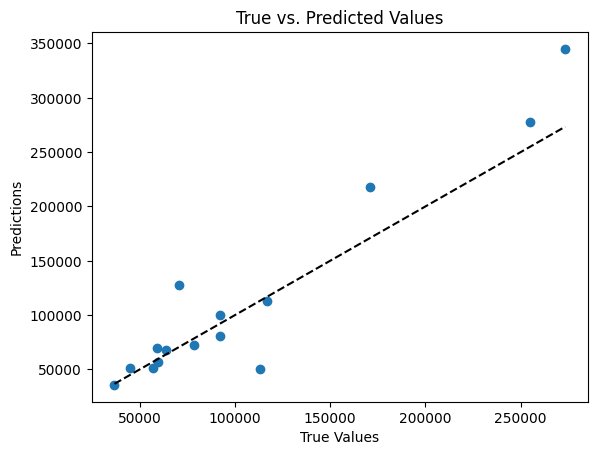

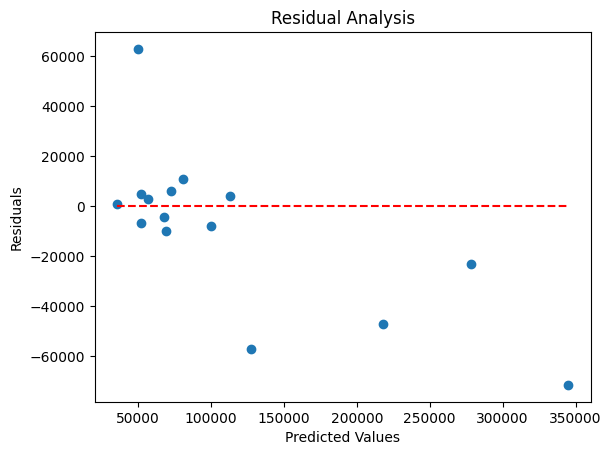

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_93357/2854259438.py:43: RuntimeWarning: overflow encountered in power
  dt_predicted['predicted_price'] = np.power(10, predicted_price_DT)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,2,1580.0,56800.0,16954.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,False,True,7,1.5,inf
1,1,1395.0,139999.0,19407.0,74000.0,1100.0,6.40,27819.0,30947.0,5,1770.975057,4,60.1815,False,False,False,True,False,False,False,False,False,True,False,4,1.5,inf
2,2,1395.0,94800.0,18002.0,92434.0,1100.0,4.30,31231.0,35724.0,5,1543.764172,4,63.9665,False,False,False,True,False,False,False,True,False,True,False,6,1.5,inf
3,2,2979.0,278000.0,39781.0,38800.0,3160.0,4.90,107313.0,165164.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
4,1,2979.0,273500.0,39330.0,78000.0,257.0,5.18,93071.0,139528.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,1395.0,45800.0,15902.0,120893.0,920.0,2.40,22519.0,13527.0,5,1639.909297,4,40.1210,False,True,False,False,False,False,True,True,False,True,False,8,1.5,inf
71,3,1998.0,60800.0,14900.0,118000.0,1110.0,3.50,17342.0,17342.0,2,1108.843537,4,45.0415,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
72,2,1988.0,218000.0,53040.0,115000.0,220.0,3.17,70951.0,99712.0,2,1335.147392,4,54.1255,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
73,2,1395.0,23800.0,17408.0,126000.0,920.0,0.90,27195.0,15073.0,4,1529.705215,4,49.9620,False,False,False,False,False,False,True,True,False,True,False,9,1.5,inf


In [109]:
from sklearn.tree import DecisionTreeRegressor


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_DT_train, y_DT_train)
y_DT_pred = dt_regressor.predict(X_DT_test)

#Calculating R Squared
n_DT = X_DT_test.shape[0]  # number of observations
p_DT = X_DT_test.shape[1]  # number of features
mae_DT = mean_absolute_error(y_DT_test, y_DT_pred)
mse_DT = mean_squared_error(y_DT_test, y_DT_pred)
rmse_DT = mean_squared_error(y_DT_test, y_DT_pred, squared=False)
r2_DT = r2_score(y_DT_test, y_DT_pred)
adjusted_r2_DT = 1 - (1 - r2_DT) * ((n_DT - 1) / (n_DT - p_DT - 1))
print(f"MAE: {mae_DT}")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2: {r2_DT}")
print(f"Adjusted R^2: {adjusted_r2_DT}")

#plotting True VS Predicted
plt.scatter(y_DT_test, y_DT_pred)
plt.plot([y_DT_test.min(), y_DT_test.max()], [y_DT_test.min(), y_DT_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_DT = y_DT_test - y_DT_pred
plt.scatter(y_DT_pred, residuals_DT)
plt.hlines(y=0, xmin=y_DT_pred.min(), xmax=y_DT_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_DT = dt_regressor.predict(x)
dt_predicted = data.copy()
dt_predicted['predicted_price'] = np.power(10, predicted_price_DT)
dt_predicted

# Random Forest

In [110]:
# split the data up for testing

X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 14071.051333333335
MSE: 360192974.6665668
RMSE: 18978.750608682512
R^2: 0.9270305874537965
Adjusted R^2: 1.2043143551293698


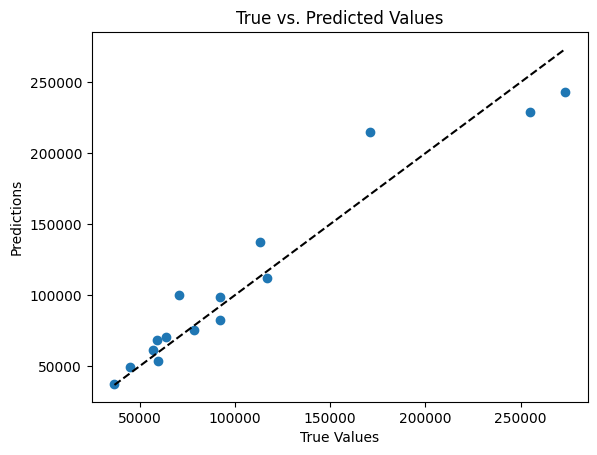

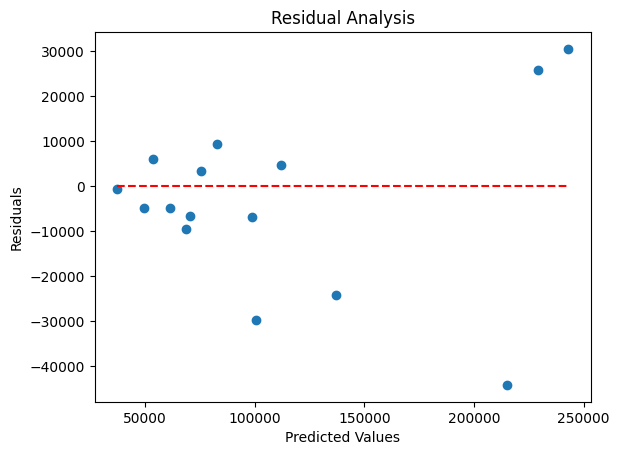

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_93357/1384493872.py:42: RuntimeWarning: overflow encountered in power
  rf_predicted['predicted_price'] = np.power(10, predicted_price_RF)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,2,1580.0,56800.0,16954.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,False,True,7,1.5,inf
1,1,1395.0,139999.0,19407.0,74000.0,1100.0,6.40,27819.0,30947.0,5,1770.975057,4,60.1815,False,False,False,True,False,False,False,False,False,True,False,4,1.5,inf
2,2,1395.0,94800.0,18002.0,92434.0,1100.0,4.30,31231.0,35724.0,5,1543.764172,4,63.9665,False,False,False,True,False,False,False,True,False,True,False,6,1.5,inf
3,2,2979.0,278000.0,39781.0,38800.0,3160.0,4.90,107313.0,165164.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
4,1,2979.0,273500.0,39330.0,78000.0,257.0,5.18,93071.0,139528.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,1395.0,45800.0,15902.0,120893.0,920.0,2.40,22519.0,13527.0,5,1639.909297,4,40.1210,False,True,False,False,False,False,True,True,False,True,False,8,1.5,inf
71,3,1998.0,60800.0,14900.0,118000.0,1110.0,3.50,17342.0,17342.0,2,1108.843537,4,45.0415,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
72,2,1988.0,218000.0,53040.0,115000.0,220.0,3.17,70951.0,99712.0,2,1335.147392,4,54.1255,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
73,2,1395.0,23800.0,17408.0,126000.0,920.0,0.90,27195.0,15073.0,4,1529.705215,4,49.9620,False,False,False,False,False,False,True,True,False,True,False,9,1.5,inf


In [111]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees
rf_regressor.fit(X_RF_train, y_RF_train)
y_RF_pred = rf_regressor.predict(X_RF_test)

# Calculating R-Squared
n_RF = X_RF_test.shape[0]  # number of observations
p_RF = X_RF_test.shape[1]  # number of features
mae_RF = mean_absolute_error(y_RF_test, y_RF_pred)
mse_RF = mean_squared_error(y_RF_test, y_RF_pred)
rmse_RF = mean_squared_error(y_RF_test, y_RF_pred, squared=False)
r2_RF = r2_score(y_RF_test, y_RF_pred)
adjusted_r2_RF = 1 - (1 - r2_RF) * ((n_RF - 1) / (n_RF - p_RF - 1))
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"RMSE: {rmse_RF}")
print(f"R^2: {r2_RF}")
print(f"Adjusted R^2: {adjusted_r2_RF}")

#plotting True VS Predicted
plt.scatter(y_RF_test, y_RF_pred)
plt.plot([y_RF_test.min(), y_RF_test.max()], [y_RF_test.min(), y_RF_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_RF = y_RF_test - y_RF_pred
plt.scatter(y_RF_pred, residuals_RF)
plt.hlines(y=0, xmin=y_RF_pred.min(), xmax=y_RF_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_RF = rf_regressor.predict(x)
rf_predicted = data.copy()
rf_predicted['predicted_price'] = np.power(10, predicted_price_RF)
rf_predicted

# Gradient Boosting

In [112]:
# split the data up for testing

X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 13824.48794757541
MSE: 417652922.748835
RMSE: 20436.558485929938
R^2: 0.9153901087343551
Adjusted R^2: 1.2369076955438056


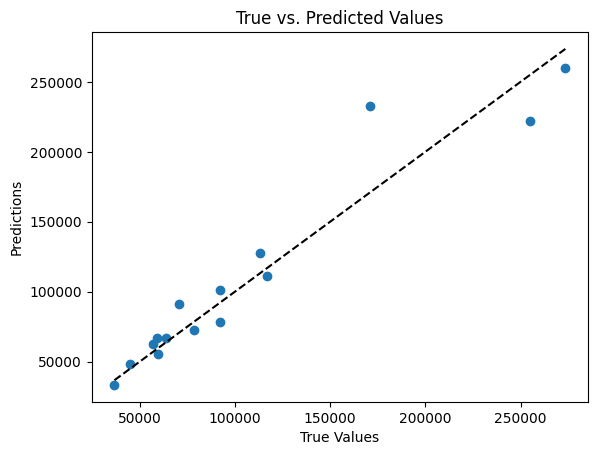

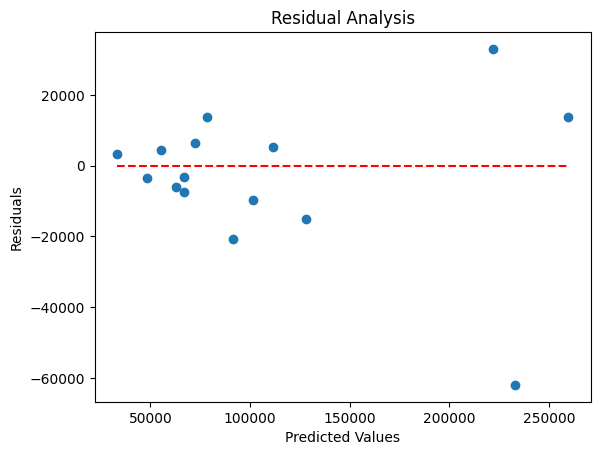

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_93357/1410396179.py:42: RuntimeWarning: overflow encountered in power
  gb_predicted['predicted_price'] = np.power(10, predicted_price_GB)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,2,1580.0,56800.0,16954.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,False,True,7,1.5,inf
1,1,1395.0,139999.0,19407.0,74000.0,1100.0,6.40,27819.0,30947.0,5,1770.975057,4,60.1815,False,False,False,True,False,False,False,False,False,True,False,4,1.5,inf
2,2,1395.0,94800.0,18002.0,92434.0,1100.0,4.30,31231.0,35724.0,5,1543.764172,4,63.9665,False,False,False,True,False,False,False,True,False,True,False,6,1.5,inf
3,2,2979.0,278000.0,39781.0,38800.0,3160.0,4.90,107313.0,165164.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
4,1,2979.0,273500.0,39330.0,78000.0,257.0,5.18,93071.0,139528.0,5,2108.843537,6,79.8635,False,False,False,True,False,False,False,False,False,True,False,5,1.5,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,1395.0,45800.0,15902.0,120893.0,920.0,2.40,22519.0,13527.0,5,1639.909297,4,40.1210,False,True,False,False,False,False,True,True,False,True,False,8,1.5,inf
71,3,1998.0,60800.0,14900.0,118000.0,1110.0,3.50,17342.0,17342.0,2,1108.843537,4,45.0415,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
72,2,1988.0,218000.0,53040.0,115000.0,220.0,3.17,70951.0,99712.0,2,1335.147392,4,54.1255,False,False,False,False,False,False,True,False,True,True,False,7,1.5,inf
73,2,1395.0,23800.0,17408.0,126000.0,920.0,0.90,27195.0,15073.0,4,1529.705215,4,49.9620,False,False,False,False,False,False,True,True,False,True,False,9,1.5,inf


In [113]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)  # 100 trees
gb_regressor.fit(X_GB_train, y_GB_train)
y_GB_pred = gb_regressor.predict(X_GB_test)

# Calculating R-Squared
n_GB = X_GB_test.shape[0]  # number of observations
p_GB = X_GB_test.shape[1]  # number of features
mae_GB = mean_absolute_error(y_GB_test, y_GB_pred)
mse_GB = mean_squared_error(y_GB_test, y_GB_pred)
rmse_GB = mean_squared_error(y_GB_test, y_GB_pred, squared=False)
r2_GB = r2_score(y_GB_test, y_GB_pred)
adjusted_r2_GB = 1 - (1 - r2_GB) * ((n_GB - 1) / (n_GB - p_GB - 1))
print(f"MAE: {mae_GB}")
print(f"MSE: {mse_GB}")
print(f"RMSE: {rmse_GB}")
print(f"R^2: {r2_GB}")
print(f"Adjusted R^2: {adjusted_r2_GB}")

#plotting True VS Predicted
plt.scatter(y_GB_test, y_GB_pred)
plt.plot([y_GB_test.min(), y_GB_test.max()], [y_GB_test.min(), y_GB_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_GB = y_GB_test - y_GB_pred
plt.scatter(y_GB_pred, residuals_GB)
plt.hlines(y=0, xmin=y_GB_pred.min(), xmax=y_GB_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_GB = gb_regressor.predict(x)
gb_predicted = data.copy()
gb_predicted['predicted_price'] = np.power(10, predicted_price_GB)
gb_predicted

In [114]:
from sklearn.model_selection import cross_val_score

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# For regression, it's common to use negative mean squared error as the scoring method
scores = cross_val_score(gb_regressor, independent_vars, Y, cv=10, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()  # Negate to get positive MSE
rmse = mean_mse ** 0.5  # Calculate RMSE from MSE

print(f"Mean MSE from 10-fold CV: {mean_mse}")
print(f"Mean RMSE from 10-fold CV: {rmse}")


Mean MSE from 10-fold CV: 370702952.09541714
Mean RMSE from 10-fold CV: 19253.647760759963


The cross-validation results show a Mean MSE of approximately 0.0017 and a Mean RMSE of approximately 0.0415. These values are quite close to the ones previously reported from a single train-test split (MSE: 0.001674, RMSE: 0.0409), which suggests the model is performing consistently across different subsets of the data and is not likely to be overfitted